In [40]:
!pip install torch numpy pandas scikit-learn matplotlib imblearn seaborn

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [42]:
data = pd.read_csv("/content/loan_data.csv")

print(f"Original shape: {data.shape}")

for col in data.columns:
    if data[col].dtype in ['int64', 'float64']:
        data[col] = data[col].fillna(data[col].median())
    else:
        data[col] = data[col].fillna(data[col].mode()[0])

if 'person_age' in data.columns and 'person_income' in data.columns:
    data['income_per_age'] = data['person_income'] / (data['person_age'] + 1)

if 'loan_amnt' in data.columns and 'person_income' in data.columns:
    data['loan_to_income_ratio'] = data['loan_amnt'] / (data['person_income'] + 1)

if 'loan_int_rate' in data.columns and 'loan_amnt' in data.columns:
    data['total_interest'] = data['loan_int_rate'] * data['loan_amnt'] / 100

if 'loan_percent_income' in data.columns:
    data['log_percent_income'] = np.log1p(data['loan_percent_income'])

Original shape: (45000, 14)


In [43]:
data = pd.get_dummies(
    data,
    columns=["person_gender", "person_education", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file"],
    drop_first=True
)

X = data.drop(columns=["loan_status"])
y = data["loan_status"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [44]:
selector = SelectKBest(f_classif, k=min(20, X.shape[1]))
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X.columns[selector.get_support()]
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [45]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [46]:
class LorentzianNN(nn.Module):
    def __init__(self, input_dim):
        super(LorentzianNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)

        self.dropout = nn.Dropout(0.4)

    def lorentzian_activation(self, x):
        return 1 / (1 + x ** 2)

    def forward(self, x):
        x = self.lorentzian_activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.fc4(x))
        x = self.fc5(x)
        return x

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_models = 3
models = []

for i in range(num_models):
    model = LorentzianNN(input_dim=X_train_tensor.shape[1]).to(device)
    models.append(model)

Using device: cuda


In [48]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return loss.mean()

In [49]:
def train_model(model_idx, model, train_loader, val_loader):
    criterion = FocalLoss()

    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.001,
        steps_per_epoch=len(train_loader),
        epochs=40,
        pct_start=0.3
    )

    num_epochs = 40
    best_val_loss = float("inf")
    patience, patience_counter = 7, 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss, train_correct, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * X_batch.size(0)
            train_correct += (output.argmax(dim=1) == y_batch).sum().item()
            total_train += X_batch.size(0)

        train_loss /= total_train
        train_acc = train_correct / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, val_correct, total_val = 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                val_correct += (output.argmax(dim=1) == y_batch).sum().item()
                total_val += X_batch.size(0)

        val_loss /= total_val
        val_acc = val_correct / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Model {model_idx+1} - Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if epoch > 10 and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_{model_idx}.pth")
            patience_counter = 0
        elif epoch > 10:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Model {model_idx+1} - Early stopping triggered!")
                break

    model.load_state_dict(torch.load(f"best_model_{model_idx}.pth"))
    return train_losses, val_losses, train_accs, val_accs

In [50]:
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []

for i, model in enumerate(models):
    print(f"Training model {i+1}/{num_models}")
    train_losses, val_losses, train_accs, val_accs = train_model(i, model, train_loader, val_loader)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

Training model 1/3
Model 1 - Epoch 1/40 | Train Loss: 0.0453 | Train Acc: 0.5000 | Val Loss: 0.0387 | Val Acc: 0.7778
Model 1 - Epoch 2/40 | Train Loss: 0.0438 | Train Acc: 0.4992 | Val Loss: 0.0404 | Val Acc: 0.7778
Model 1 - Epoch 3/40 | Train Loss: 0.0437 | Train Acc: 0.4957 | Val Loss: 0.0409 | Val Acc: 0.7778
Model 1 - Epoch 4/40 | Train Loss: 0.0435 | Train Acc: 0.5012 | Val Loss: 0.0431 | Val Acc: 0.6655
Model 1 - Epoch 5/40 | Train Loss: 0.0435 | Train Acc: 0.5009 | Val Loss: 0.0421 | Val Acc: 0.7778
Model 1 - Epoch 6/40 | Train Loss: 0.0434 | Train Acc: 0.4994 | Val Loss: 0.0423 | Val Acc: 0.7778
Model 1 - Epoch 7/40 | Train Loss: 0.0434 | Train Acc: 0.4992 | Val Loss: 0.0441 | Val Acc: 0.2222
Model 1 - Epoch 8/40 | Train Loss: 0.0434 | Train Acc: 0.5007 | Val Loss: 0.0430 | Val Acc: 0.7401
Model 1 - Epoch 9/40 | Train Loss: 0.0434 | Train Acc: 0.5017 | Val Loss: 0.0417 | Val Acc: 0.7778
Model 1 - Epoch 10/40 | Train Loss: 0.0434 | Train Acc: 0.5016 | Val Loss: 0.0416 | Val Ac

<ipython-input-49-4a1966155fee>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{model_idx}.pth"))


Model 2 - Epoch 1/40 | Train Loss: 0.0442 | Train Acc: 0.5006 | Val Loss: 0.0432 | Val Acc: 0.5227
Model 2 - Epoch 2/40 | Train Loss: 0.0438 | Train Acc: 0.5012 | Val Loss: 0.0433 | Val Acc: 0.5147
Model 2 - Epoch 3/40 | Train Loss: 0.0437 | Train Acc: 0.4979 | Val Loss: 0.0422 | Val Acc: 0.7664
Model 2 - Epoch 4/40 | Train Loss: 0.0436 | Train Acc: 0.4992 | Val Loss: 0.0421 | Val Acc: 0.7778
Model 2 - Epoch 5/40 | Train Loss: 0.0435 | Train Acc: 0.4991 | Val Loss: 0.0430 | Val Acc: 0.7316
Model 2 - Epoch 6/40 | Train Loss: 0.0434 | Train Acc: 0.5043 | Val Loss: 0.0457 | Val Acc: 0.2222
Model 2 - Epoch 7/40 | Train Loss: 0.0434 | Train Acc: 0.5015 | Val Loss: 0.0444 | Val Acc: 0.2222
Model 2 - Epoch 8/40 | Train Loss: 0.0434 | Train Acc: 0.5033 | Val Loss: 0.0420 | Val Acc: 0.7778
Model 2 - Epoch 9/40 | Train Loss: 0.0434 | Train Acc: 0.4963 | Val Loss: 0.0445 | Val Acc: 0.2222
Model 2 - Epoch 10/40 | Train Loss: 0.0434 | Train Acc: 0.5025 | Val Loss: 0.0447 | Val Acc: 0.2225
Model 2 -

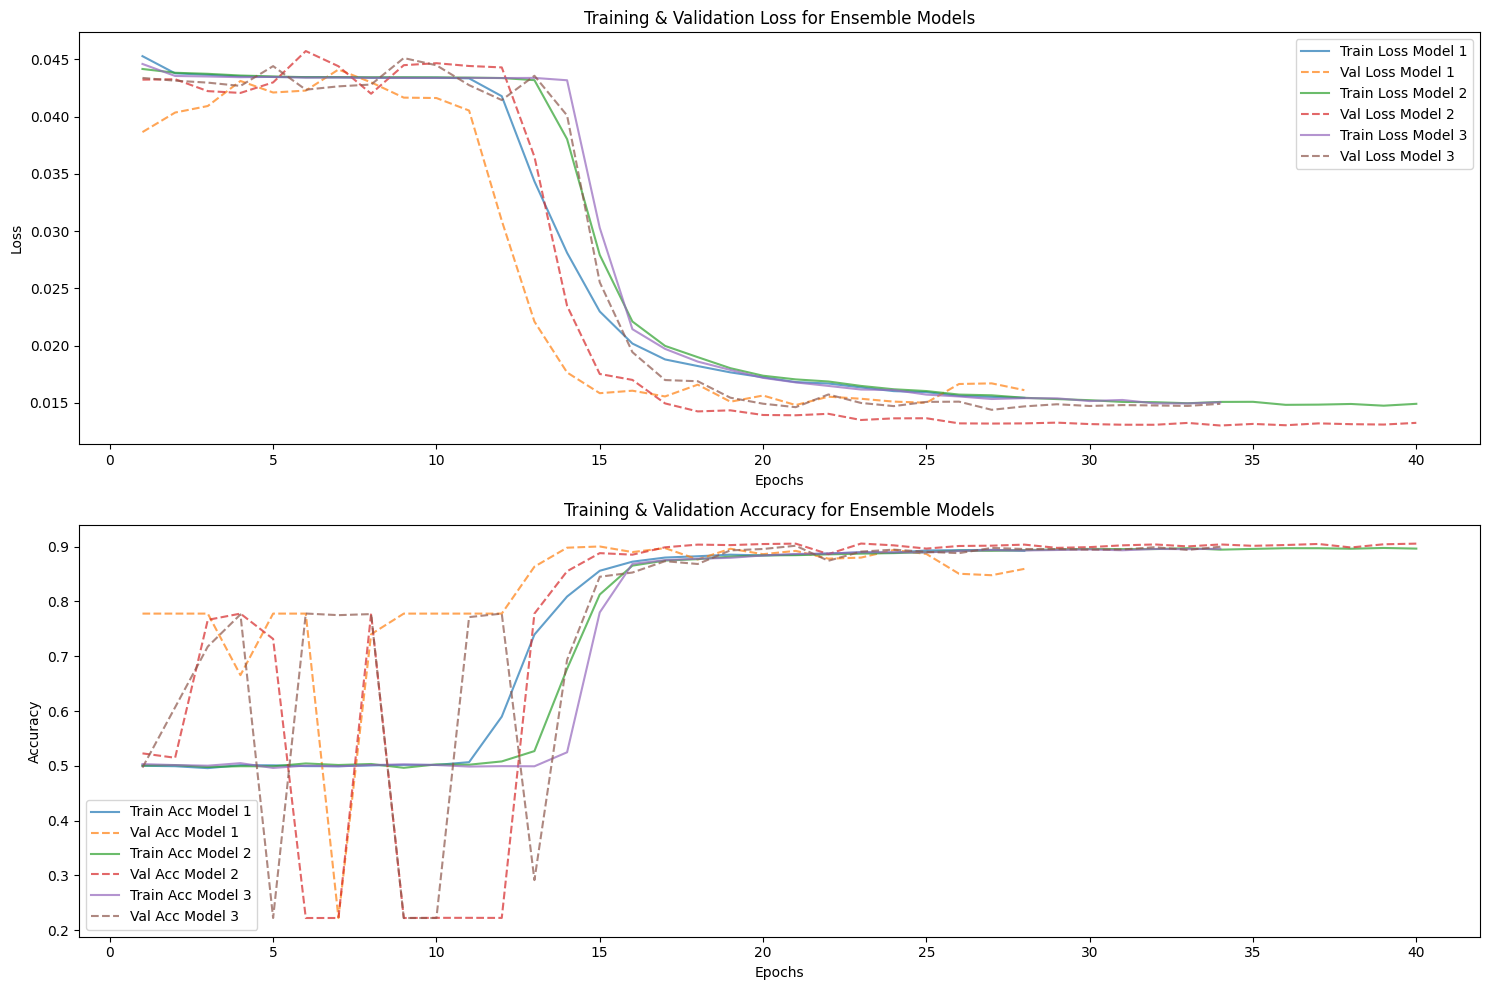

In [51]:
def plot_ensemble_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    for i, (train_losses, val_losses) in enumerate(zip(all_train_losses, all_val_losses)):
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, '-', label=f'Train Loss Model {i+1}', alpha=0.7)
        plt.plot(epochs, val_losses, '--', label=f'Val Loss Model {i+1}', alpha=0.7)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss for Ensemble Models')
    plt.legend()

    plt.subplot(2, 1, 2)
    for i, (train_accs, val_accs) in enumerate(zip(all_train_accs, all_val_accs)):
        epochs = range(1, len(train_accs) + 1)
        plt.plot(epochs, train_accs, '-', label=f'Train Acc Model {i+1}', alpha=0.7)
        plt.plot(epochs, val_accs, '--', label=f'Val Acc Model {i+1}', alpha=0.7)

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy for Ensemble Models')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_ensemble_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs)

In [52]:
def test_ensemble(models, test_loader, device):
    for i, model in enumerate(models):
        model.eval()
        model.load_state_dict(torch.load(f"best_model_{i}.pth"))

    test_correct, total_test = 0, 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            batch_preds = []
            for model in models:
                output = model(X_batch)
                batch_preds.append(output)

            ensemble_output = torch.mean(torch.stack([p for p in batch_preds]), dim=0)
            probabilities = torch.nn.functional.softmax(ensemble_output, dim=1)
            predicted = ensemble_output.argmax(dim=1)

            test_correct += (predicted == y_batch).sum().item()
            total_test += X_batch.size(0)

            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
            all_probs.append(probabilities[:, 1].cpu().numpy())

    test_acc = test_correct / total_test
    print(f"Ensemble Test Accuracy: {test_acc:.6f} ({test_correct}/{total_test})")

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    return test_acc, all_preds, all_labels, all_probs

ensemble_acc, all_preds, all_labels, all_probs = test_ensemble(models, test_loader, device)

<ipython-input-52-92759a53ca96>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{i}.pth"))


Ensemble Test Accuracy: 0.903704 (6100/6750)


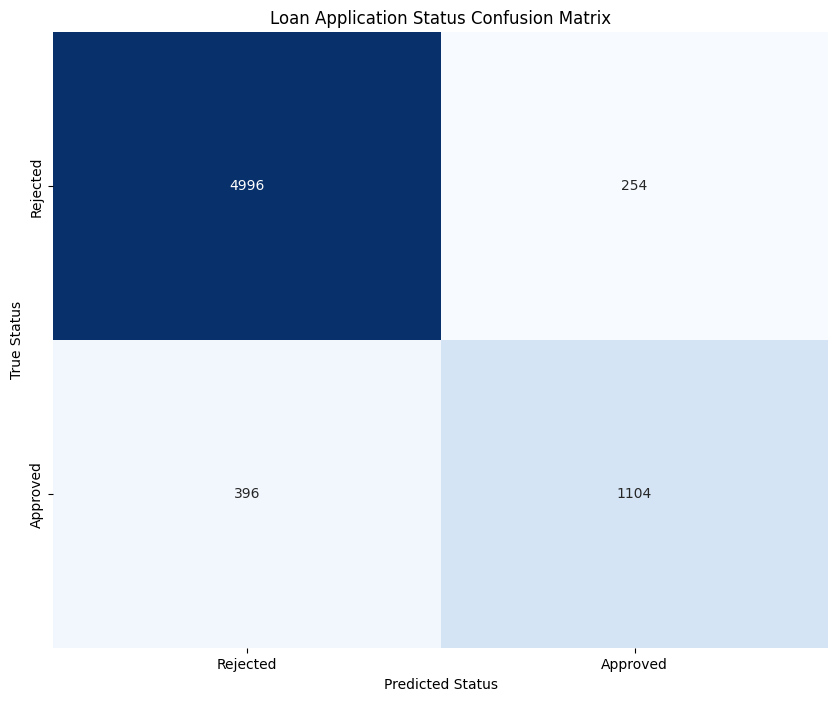

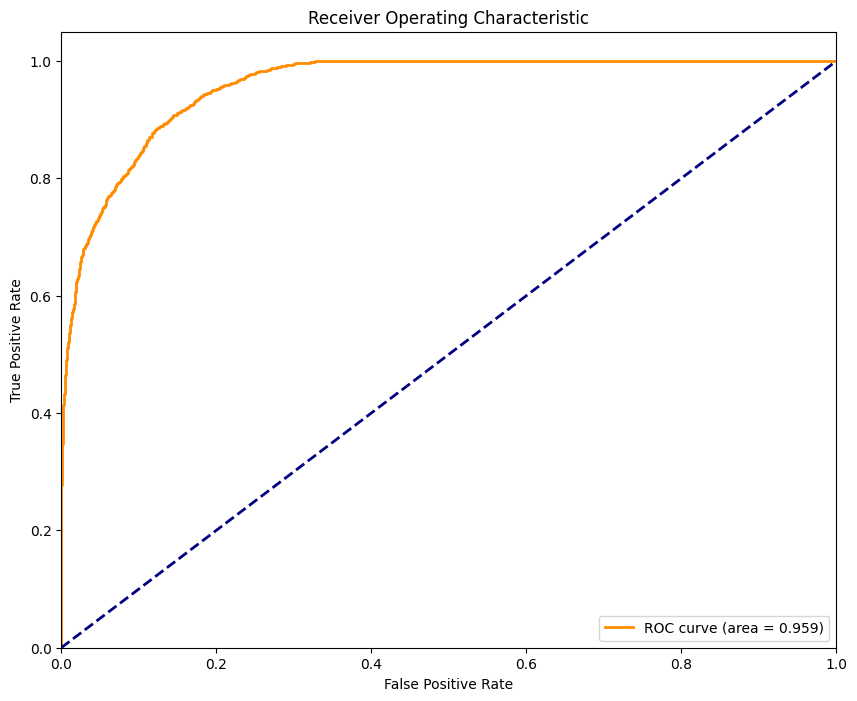


Classification Report:
Loan Status: Rejected
  Precision: 0.9266
  Recall: 0.9516
  F1-score: 0.9389
  Support: 5250.0
Loan Status: Approved
  Precision: 0.8130
  Recall: 0.7360
  F1-score: 0.7726
  Support: 1500.0

Overall Accuracy: 0.9037


In [53]:
def evaluate_model_performance(all_preds, all_labels, all_probs):
    label_names = {0: "Rejected", 1: "Approved"}

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Loan Application Status Confusion Matrix')
    plt.ylabel('True Status')
    plt.xlabel('Predicted Status')

    plt.yticks([0.5, 1.5], [label_names[0], label_names[1]])
    plt.xticks([0.5, 1.5], [label_names[0], label_names[1]])
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    report = classification_report(all_labels, all_preds, output_dict=True)

    print("\nClassification Report:")
    for label in ['0', '1']:
        metrics = report[label]
        print(f"Loan Status: {label_names[int(label)]}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")
        print(f"  Support: {metrics['support']}")

    print(f"\nOverall Accuracy: {report['accuracy']:.4f}")

    return report['accuracy']

final_accuracy = evaluate_model_performance(all_preds, all_labels, all_probs)

In [54]:
ensemble_data = {}
for i, model in enumerate(models):
    model.load_state_dict(torch.load(f"best_model_{i}.pth"))
    ensemble_data[f'model_{i}'] = model.state_dict()

ensemble_data['feature_names'] = list(selected_features)
torch.save(ensemble_data, 'loan_approval_ensemble_model.pth')

<ipython-input-54-465164955ce1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{i}.pth"))


In [55]:
def predict_with_ensemble(new_data, device=device):
    ensemble_data = torch.load('loan_approval_ensemble_model.pth')
    feature_names = ensemble_data['feature_names']

    input_dim = len(feature_names)
    models = []

    for i in range(len([k for k in ensemble_data.keys() if k.startswith('model_')])):
        model = LorentzianNN(input_dim=input_dim).to(device)
        model.load_state_dict(ensemble_data[f'model_{i}'])
        model.eval()
        models.append(model)

    for feature in feature_names:
        if feature not in new_data.columns:
            new_data[feature] = 0

    X = new_data[feature_names].values
    X_scaled = scaler.transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    all_outputs = []
    with torch.no_grad():
        for model in models:
            outputs = model(X_tensor)
            all_outputs.append(outputs)

        ensemble_output = torch.mean(torch.stack([p for p in all_outputs]), dim=0)
        probabilities = torch.nn.functional.softmax(ensemble_output, dim=1)
        predictions = ensemble_output.argmax(dim=1)

    results = pd.DataFrame({
        'prediction': predictions.cpu().numpy(),
        'probability': probabilities[:, 1].cpu().numpy()
    })

    results['status'] = results['prediction'].map({0: 'Rejected', 1: 'Approved'})

    return results